In [10]:
# import cluster_peptides as cp
import time

import argparse
import numpy as np
import subprocess
import collections
import pickle
import scipy.cluster.hierarchy as sch
import time
from Bio.Align import substitution_matrices
from joblib import Parallel, delayed
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from random import choice
import string
import os
import sys
import itertools

sys.path.append("/home/severin/3D-Vac/src/0_build_db1")
import cluster_peptides as cp

incsv = '/projects/0/einf2380/data/external/unprocessed/mhcflurry.allele_sequences.csv'

datacsv='/projects/0/einf2380/data/external/processed/I/BA_pMHCI_human_quantitative_only_eq.csv'
data = pd.read_csv(datacsv)
alleles = [x.replace('-CW', '-C') for x in set(data['allele'])]

genes = {}
with open(incsv, 'r') as infile:
    next(infile)
    for line in infile:
        row = line.replace('\n','').split(',')
        if row[0].startswith('HLA-') and row[0] in alleles: #take only human alleles used in out dataset
            try:
                genes[row[0][4]][row[0]] = row[1]
            except KeyError:
                genes[row[0][4]] = {row[0] : row[1]}
        else:
            pass
        
genes.keys()

dict_keys(['A', 'B', 'C', 'E'])

In [11]:
def get_score_matrix(peptides, n_jobs, matrix):
    #peptides = sorted(list(set(peptides)))

    batches = cp.split_in_indexed_batches(peptides, n_jobs)

    arrays = Parallel(n_jobs=n_jobs, verbose=1)(delayed(cp.get_scores)(matrix, batch, peptides) for batch in batches)
    arrays = [sorted(a, key=lambda x:x[0]) for a in arrays]

    score_array = []
    for x in arrays:
        x = [y[1] for y in x]
        score_array.extend(x)

    return score_array

def cluster_peptides(sequences, n_clusters, frag_len = 37,
                     matrix='PAM250', n_jobs=1, make_graphs=False,
                     labels=None, prefix_name=None, score_array= None, truncate_p=12):
    # matrix='PAM250'
    # n_jobs = 1
    # n_clusters = 5
    # frag_len = 37
    # make_graphs=True


    t1 = time.time()

    if labels == None:
        sequences = sorted(list(set(sequences)))
    
    if score_array:
        pass
    else:
        score_array = get_score_matrix(sequences, n_jobs, matrix)

    t2 = time.time()

    #Convert the distances in a score array
    dist_array = []
    top = max(score_array)
    for x in score_array:
        y = top + 1 - x
        dist_array.append(y)
    array = np.asarray(dist_array)

    t3 = time.time()
    #Calculate linkage between peptides (i.e. the dendrogram)
    result = sch.linkage(array, method='average')
    print(result)
    print(len(result))
    print(len(labels))

    t4 = time.time()

    #Plot dendrogram
    if make_graphs:
        plt.figure(figsize=(60, 20))
        plt.title('Sequences Hierarchical Clusterization')
        plt.xlabel('Sequences')
        plt.ylabel('Distance')
        sch.dendrogram(
            Z=result,
            leaf_rotation=90.,  # rotates the x axis labels
            leaf_font_size=8.,  # font size for the x axis labels
            show_contracted=True,
            labels = labels,
            truncate_mode='level', p=truncate_p,
        )
        plt.axhline(n_clusters, color='b')
        plt.savefig(f"../../reports/figures/pseudocluster/{prefix_name}_dendogram_{matrix}.svg")
        plt.show()
        #plt.savefig(f"../../reports/figures/{filename}_dendogram_{matrix}.png", dpi=200)
        plt.clf()

    if make_graphs:
        last = result[:,2]
        Y = last[::-1]
        idxs = np.arange(1, len(last)+1)
        plt.plot(idxs,Y)
        plt.xlabel("Distance index")
        plt.ylabel("Distance")
        plt.title(f"Ranked distances between dendogram clusters for the {matrix} matrice")

        plt.savefig(f"../../reports/figures/pseudocluster/{prefix_name}_elbow_{matrix}.svg")
        plt.show()
        #plt.savefig(f"../../reports/figures/elbow_{matrix}.png")
        plt.clf()
        #print(f"Elbow figure saved in reports/figures/{filename}_elbow_{matrix}.png")

    t5 = time.time()
    #Produce clusters using the given threshold
    fc = sch.fcluster(result, n_clusters, criterion='distance') # the number inside specifies the cutoff distance for dividing clusers
    if labels:
        ordered_clusters = sorted(zip(fc, sequences, labels))
    else: 
        ordered_clusters = sorted(zip(fc, sequences))
    clst_dct = {}
    # mtf_lst = []
    for i in set(fc):
        clst_dct['clst_%s' % (i-1)] = []
        # mtf_lst.append([])


    for clst in clst_dct:
        lenght = len(clst)
        number = clst[5:lenght]
        for i in ordered_clusters:
            if str((i[0]-1)) == (number):
                if labels:
                    clst_dct[clst].append((i[1], i[2]))
                else:
                    clst_dct[clst].append(i[1])
        # mtf_lst[(int(number))] = [[] for j in range(frag_len)]
        # for i in range(frag_len):
        #     for frag in clst_dct[clst]:
        #         if len(frag) == frag_len:
        #             mtf_lst[(int(number))][i].append(frag[i])
        #     mtf_lst[(int(number))][i] = list(set(mtf_lst[(int(number))][i]))

    t6 = time.time()

    print('Calculate distances:', t2-t1)
    print('Distances array:', t3-t2)
    print('Linkage:', t4-t3)
    print('Plot:', t5-t4)
    print('Clusters:', t6-t5)
    
    return clst_dct



In [12]:
def get_unique_alleles(sequences, hla_dict):
    ordered = collections.OrderedDict(hla_dict)
    ord_keys = list(ordered.keys())
    ord_values = list(ordered.values())
    hla_names = [ord_keys[ord_values.index(i)] for i in sequences]
    return hla_names

inv_genes = {}
for g in genes:
    inv_genes[g] = {}
    for k, v in genes[g].items():
        try:
            inv_genes[g][v].append(k)
        except KeyError:
            inv_genes[g][v] = [k]
            
names_clusters = {'A': {}, 'B':{}, 'C':{}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[[ 1.          7.          1.          2.        ]
 [ 5.         11.         22.          2.        ]
 [ 6.         12.         23.5         3.        ]
 [ 0.          9.         26.          2.        ]
 [ 2.         13.         36.          3.        ]
 [10.         14.         38.66666667  4.        ]
 [ 8.         17.         51.          5.        ]
 [ 3.         16.         51.33333333  4.        ]
 [18.         19.         62.9         9.        ]
 [ 4.         20.         74.88888889 10.        ]
 [15.         21.         97.15       12.        ]]
11
12


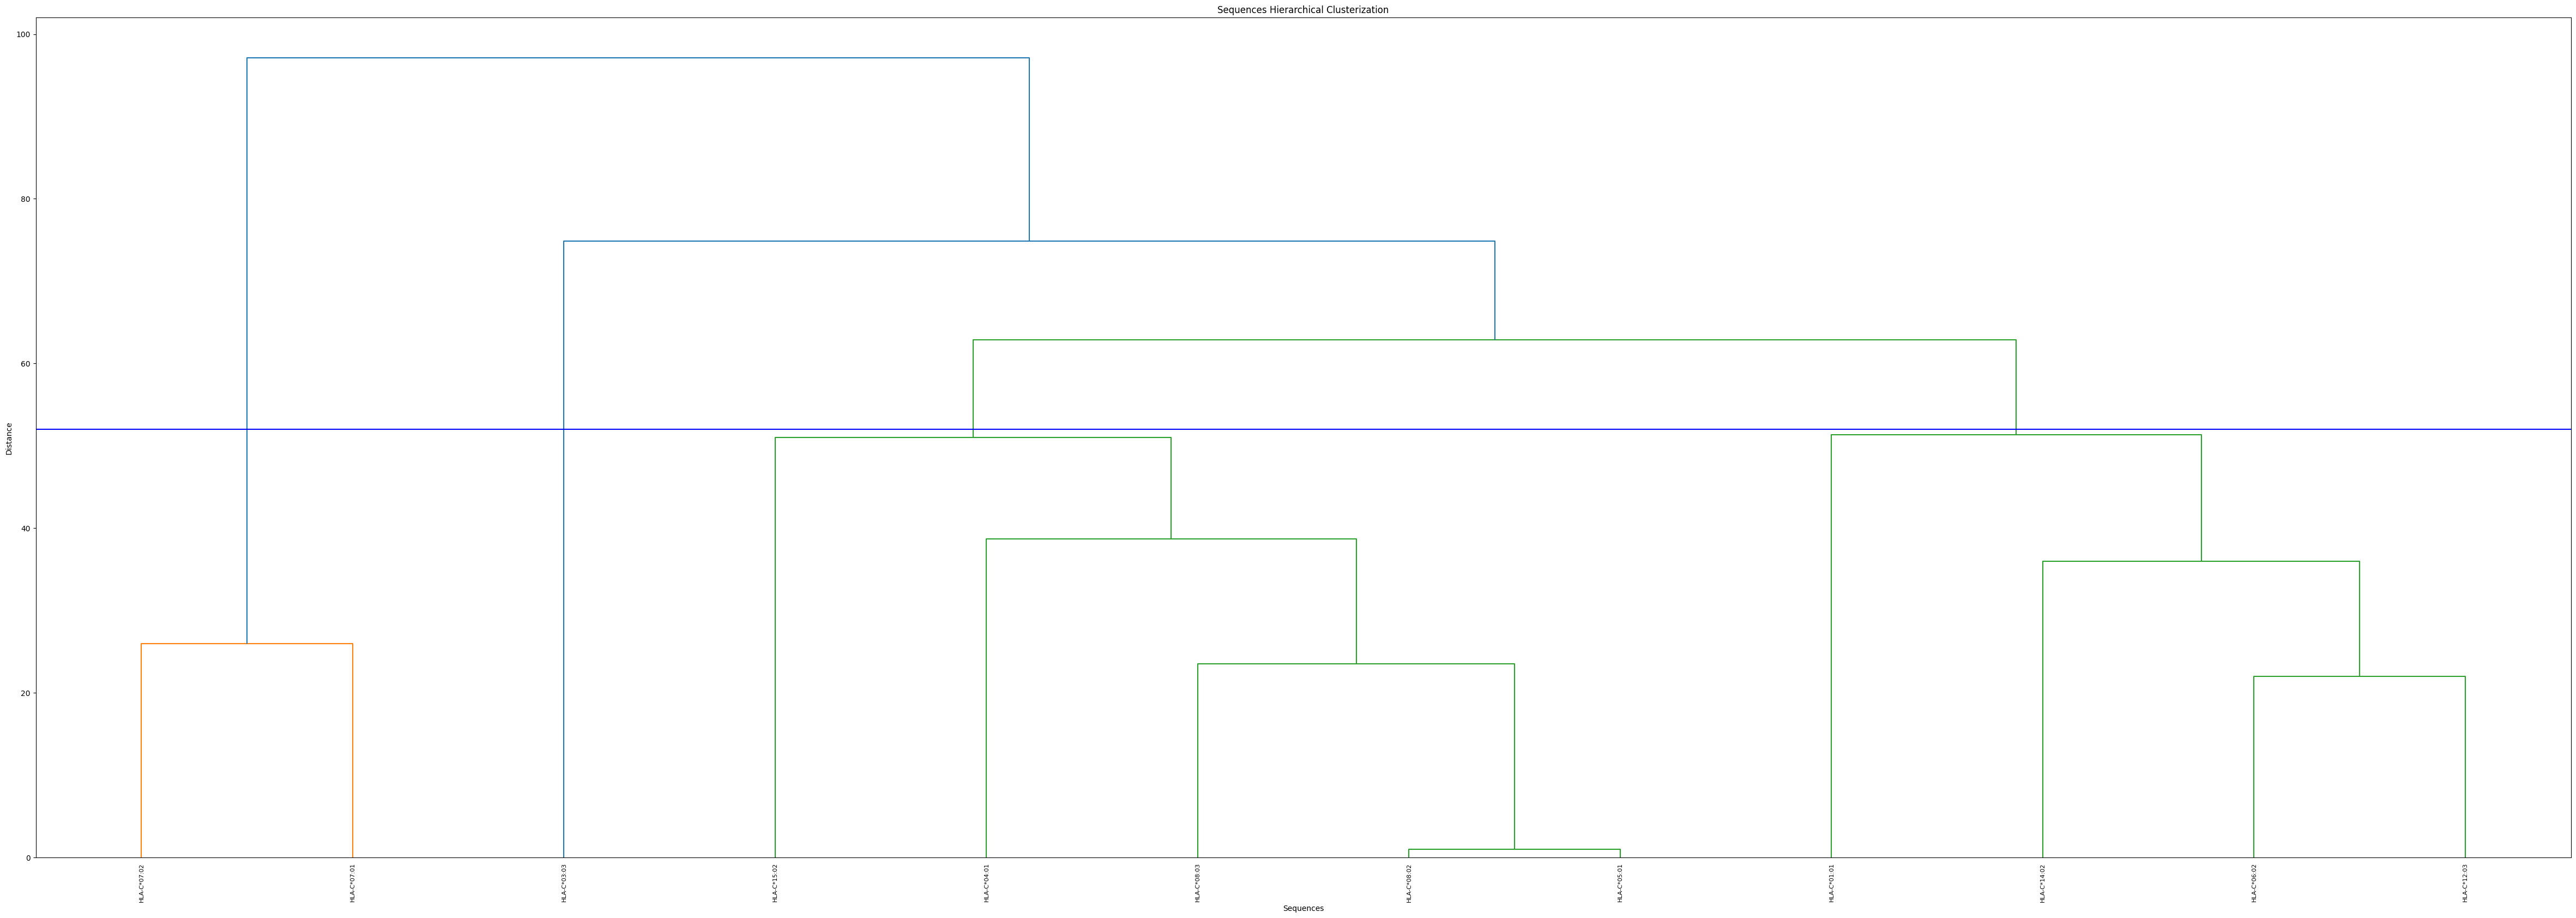

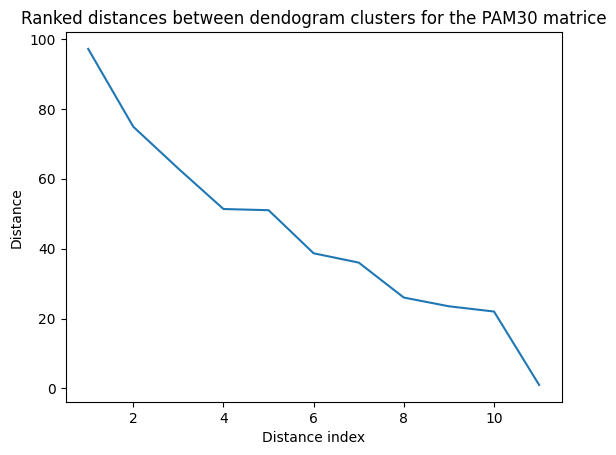

Calculate distances: 0.009661197662353516
Distances array: 3.314018249511719e-05
Linkage: 0.0005156993865966797
Plot: 0.7477800846099854
Clusters: 0.0002186298370361328
[('clst_0', 2), ('clst_1', 5), ('clst_2', 4), ('clst_3', 1)]
{'clst_0': [['HLA-C*07:01'], ['HLA-C*07:02']], 'clst_1': [['HLA-C*04:01'], ['HLA-C*05:01'], ['HLA-C*08:02'], ['HLA-C*08:03'], ['HLA-C*15:02']], 'clst_2': [['HLA-C*01:01'], ['HLA-C*06:02'], ['HLA-C*12:03'], ['HLA-C*14:02']], 'clst_3': [['HLA-C*03:03']]}


<Figure size 640x480 with 0 Axes>

In [13]:
sequences_C =list(set( list(genes['C'].values())))

labels_C= get_unique_alleles(sequences=sequences_C, hla_dict=genes['C'])

clusters_C = cluster_peptides(
    sequences=sequences_C,
    matrix='PAM30',
    n_jobs = 1,
    n_clusters = 52,
    frag_len = 37,
    make_graphs=True,
    prefix_name='C',
    labels = labels_C,
    truncate_p = 12
)

names_clusters['C'] = {clst : [name for seq, name in inv_genes['C'].items() if any(seq ==x[0] for x in clusters_C[clst])] for clst in clusters_C}
print([(n, len(names_clusters['C'][n])) for n in names_clusters['C']])
print(names_clusters['C'])

[[ 12.          26.           1.           2.        ]
 [  8.          18.           5.           2.        ]
 [ 23.          28.          10.           2.        ]
 [ 10.          29.          11.           2.        ]
 [  4.           7.          11.           2.        ]
 [ 27.          55.          13.           2.        ]
 [ 40.          45.          13.           2.        ]
 [ 14.          48.          15.           2.        ]
 [  2.          35.          17.           2.        ]
 [ 30.          60.          18.           3.        ]
 [ 32.          52.          19.           2.        ]
 [ 20.          38.          22.           2.        ]
 [ 16.          44.          22.           2.        ]
 [ 17.          63.          22.           3.        ]
 [ 59.          66.          26.33333333   5.        ]
 [ 34.          61.          26.5          3.        ]
 [ 21.          31.          28.           2.        ]
 [ 24.          33.          31.           2.        ]
 [ 46.    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


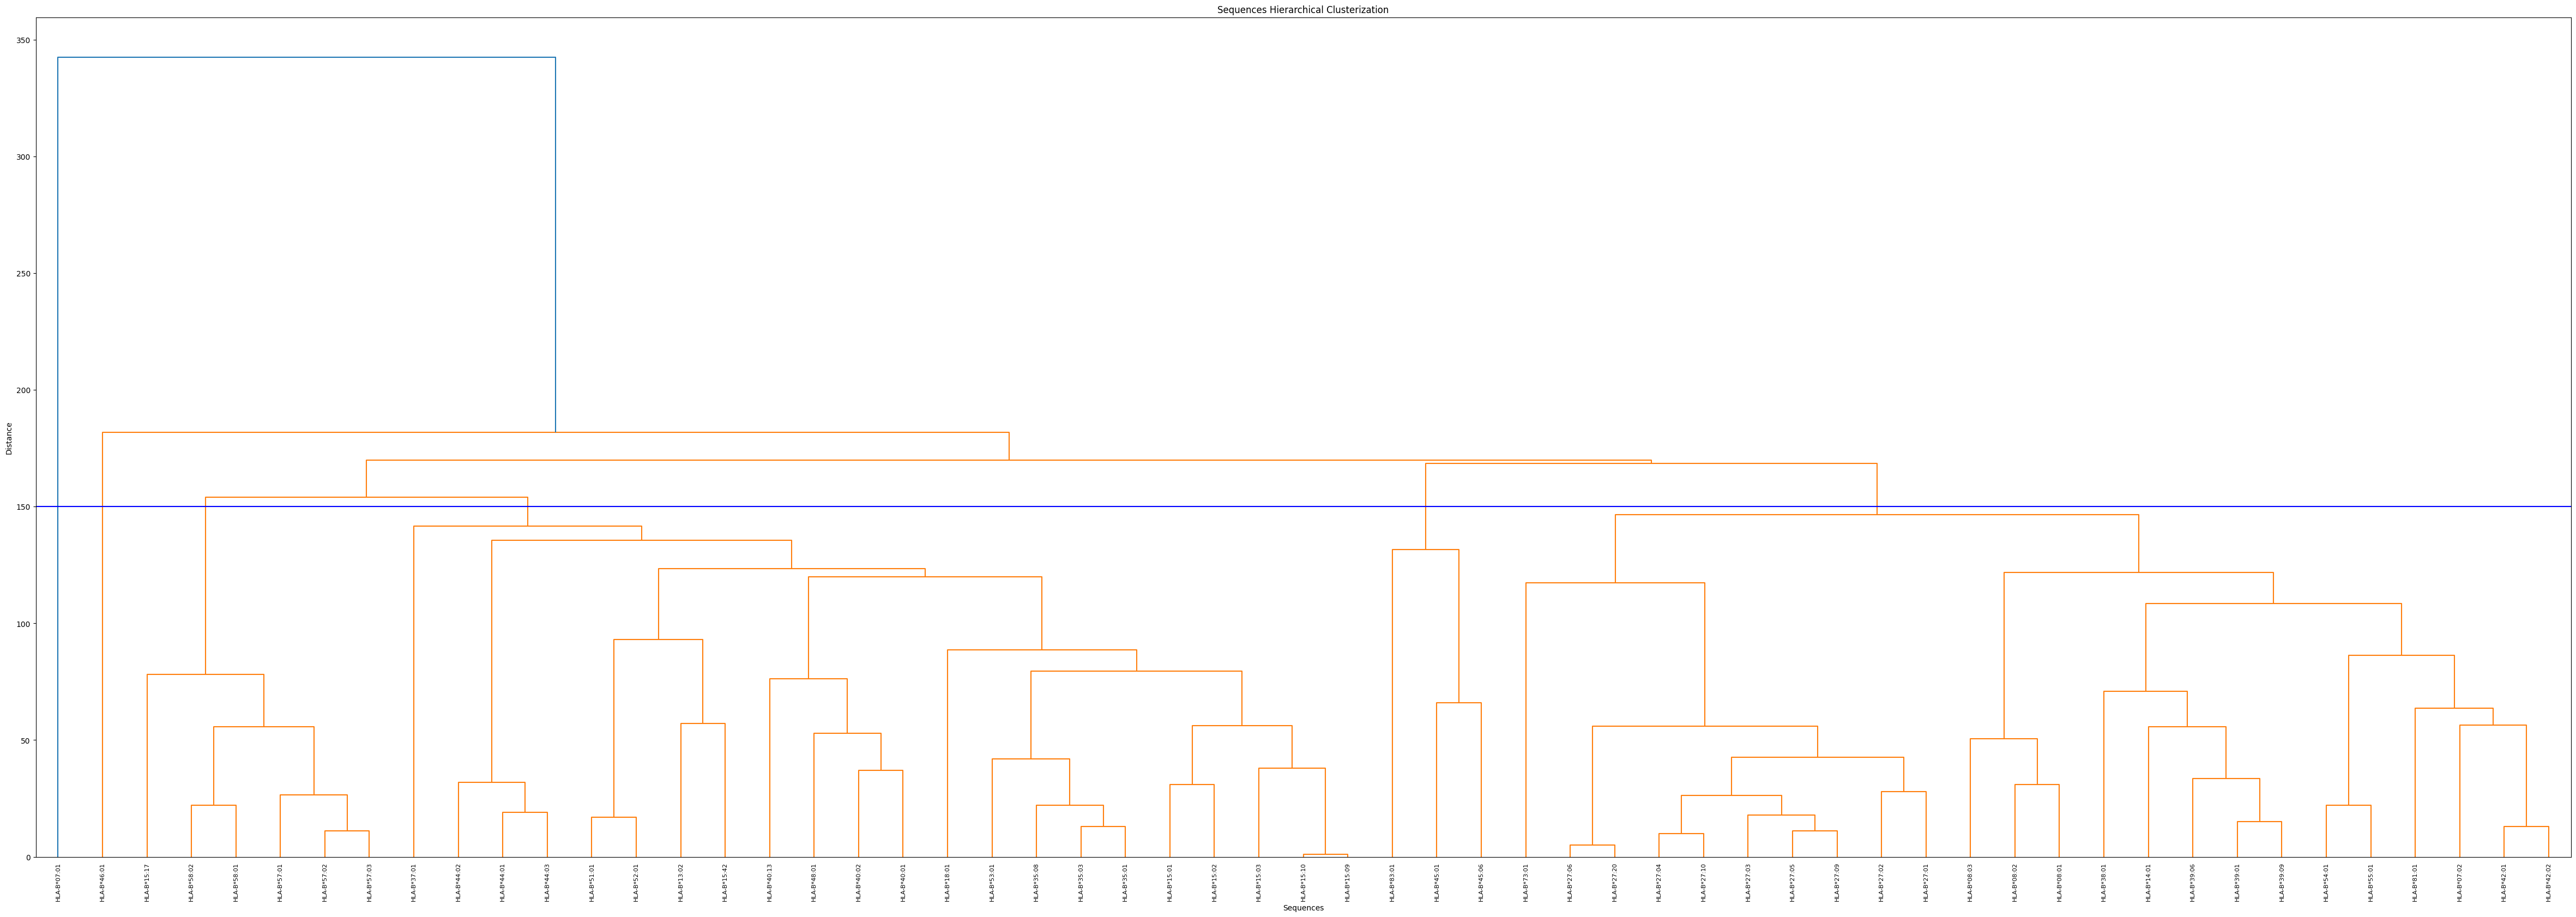

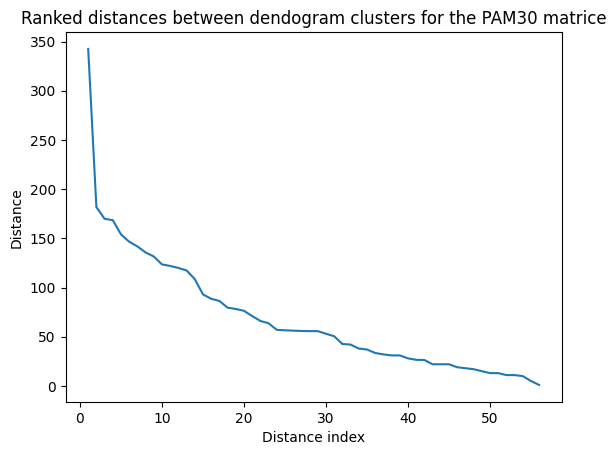

Calculate distances: 0.12735652923583984
Distances array: 0.00038933753967285156
Linkage: 0.0017538070678710938
Plot: 1.46030592918396
Clusters: 0.0009534358978271484
[('clst_0', 6), ('clst_1', 22), ('clst_2', 3), ('clst_3', 24), ('clst_4', 1), ('clst_5', 1)]
{'clst_0': [['HLA-B*15:17'], ['HLA-B*57:01'], ['HLA-B*57:02'], ['HLA-B*57:03'], ['HLA-B*58:01'], ['HLA-B*58:02']], 'clst_1': [['HLA-B*13:02'], ['HLA-B*15:01'], ['HLA-B*15:02'], ['HLA-B*15:03'], ['HLA-B*15:09'], ['HLA-B*15:10'], ['HLA-B*15:42'], ['HLA-B*18:01'], ['HLA-B*35:01'], ['HLA-B*35:03'], ['HLA-B*35:08'], ['HLA-B*37:01'], ['HLA-B*40:01'], ['HLA-B*40:02'], ['HLA-B*40:13'], ['HLA-B*44:02'], ['HLA-B*44:03'], ['HLA-B*44:01'], ['HLA-B*48:01'], ['HLA-B*51:01'], ['HLA-B*52:01'], ['HLA-B*53:01']], 'clst_2': [['HLA-B*45:01'], ['HLA-B*45:06'], ['HLA-B*83:01']], 'clst_3': [['HLA-B*07:02'], ['HLA-B*08:01'], ['HLA-B*08:02'], ['HLA-B*08:03'], ['HLA-B*14:01', 'HLA-B*14:02'], ['HLA-B*27:01'], ['HLA-B*27:02'], ['HLA-B*27:03'], ['HLA-B*27:04'

<Figure size 640x480 with 0 Axes>

In [14]:

sequences_B =list(set( list(genes['B'].values())))
labels_B = get_unique_alleles(sequences=sequences_B, hla_dict=genes['B'])

clusters_B = cluster_peptides(
    sequences=sequences_B,
    matrix='PAM30',
    n_jobs = 1,
    n_clusters = 150,
    frag_len = 37,
    make_graphs=True,
    prefix_name = 'B',
    labels = labels_B,
    truncate_p = 12
)

names_clusters['B'] = {clst : [name for seq, name in inv_genes['B'].items() if any(seq ==x[0] for x in clusters_B[clst])] for clst in clusters_B}
print([(n, len(names_clusters['B'][n])) for n in names_clusters['B']])
print(names_clusters['B'])

[[ 12.          32.           1.           2.        ]
 [  2.          24.           4.           2.        ]
 [ 25.          27.           9.           2.        ]
 [  8.          19.          10.           2.        ]
 [  3.          13.          14.           2.        ]
 [  9.          16.          16.           2.        ]
 [  4.          30.          17.           2.        ]
 [ 36.          41.          17.5          3.        ]
 [ 29.          43.          18.5          3.        ]
 [  1.          38.          19.           2.        ]
 [  6.          33.          21.           2.        ]
 [ 40.          44.          22.           4.        ]
 [ 37.          48.          22.33333333   4.        ]
 [ 28.          47.          23.           4.        ]
 [  5.          52.          25.           5.        ]
 [ 10.          39.          27.           2.        ]
 [ 22.          45.          28.5          3.        ]
 [ 11.          14.          29.           2.        ]
 [ 46.    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


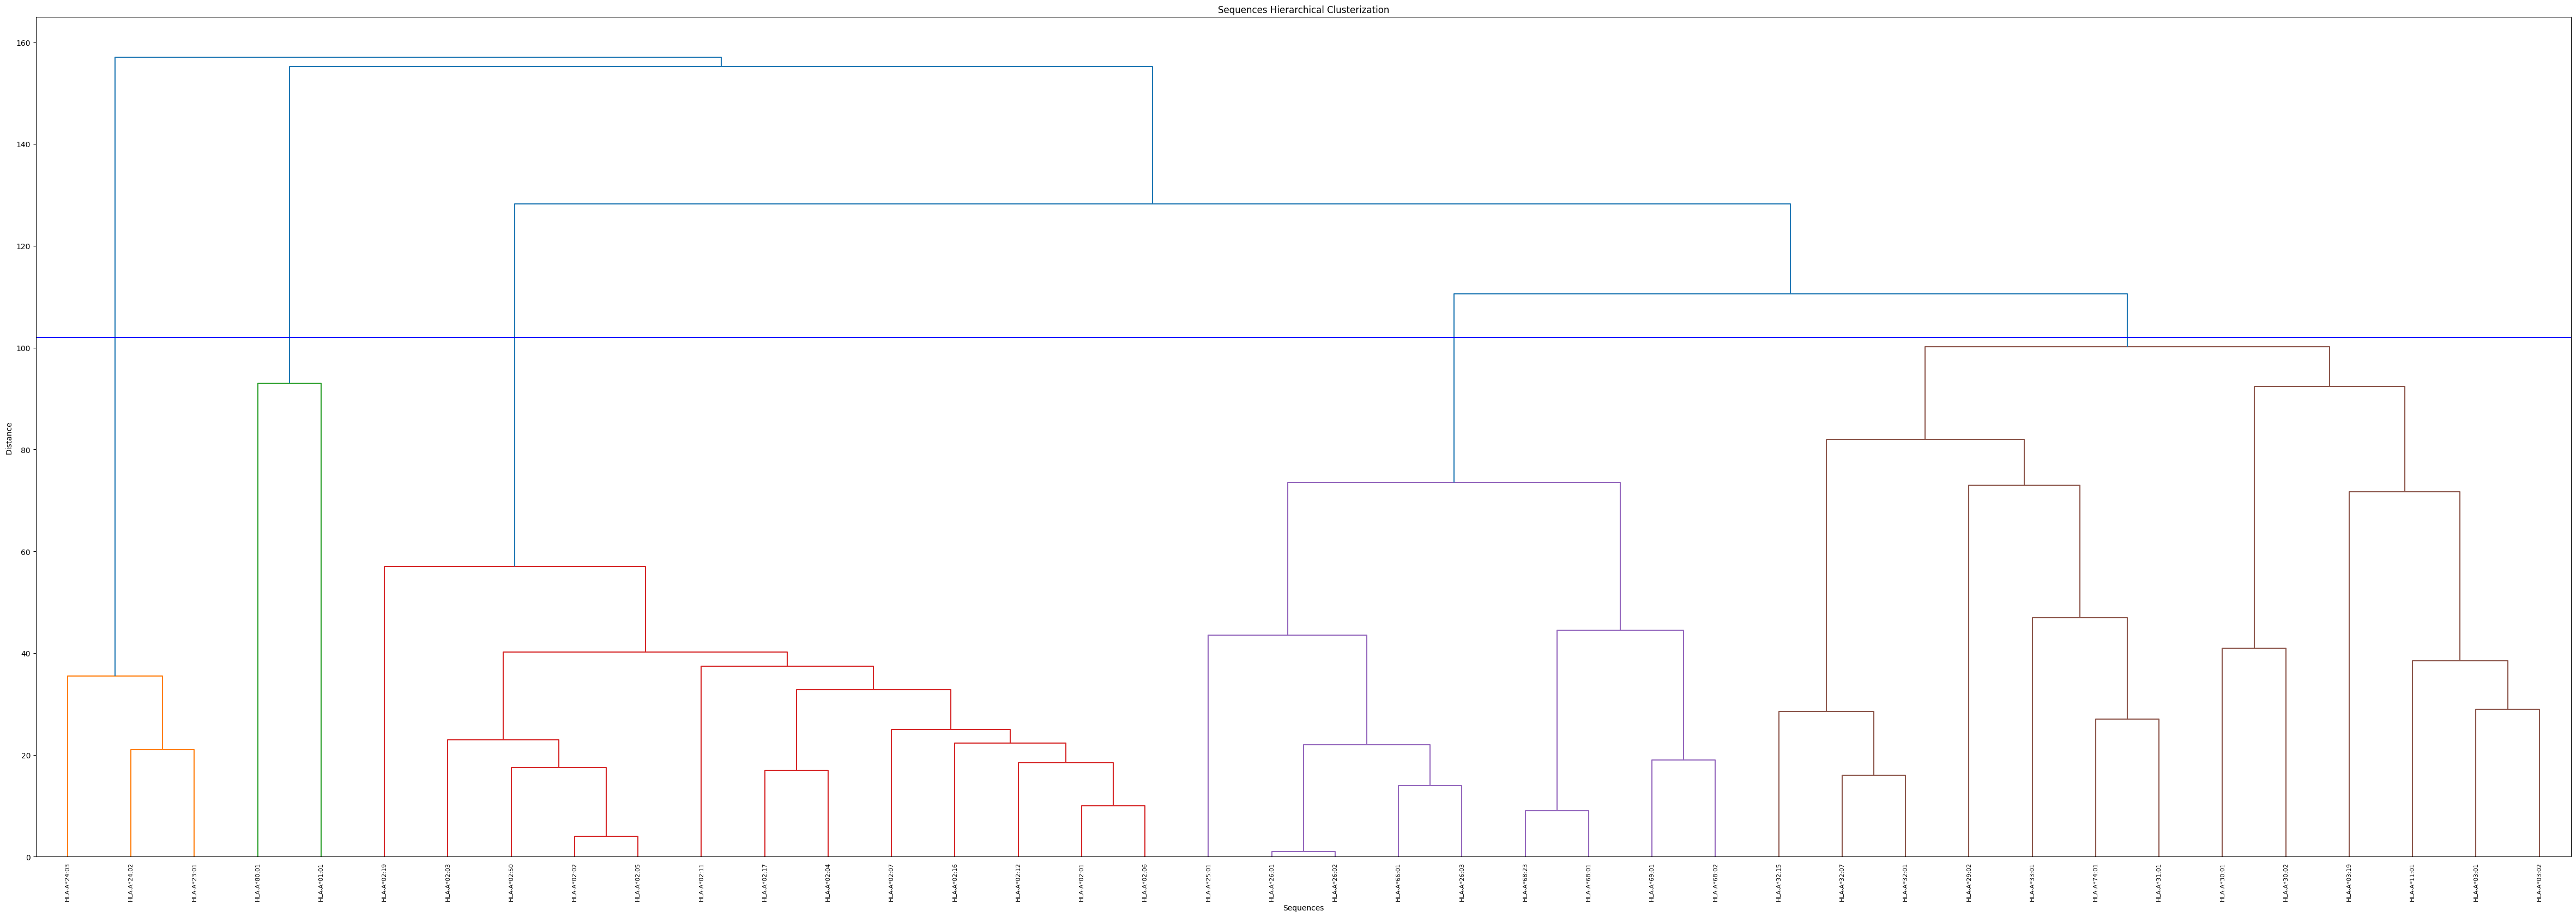

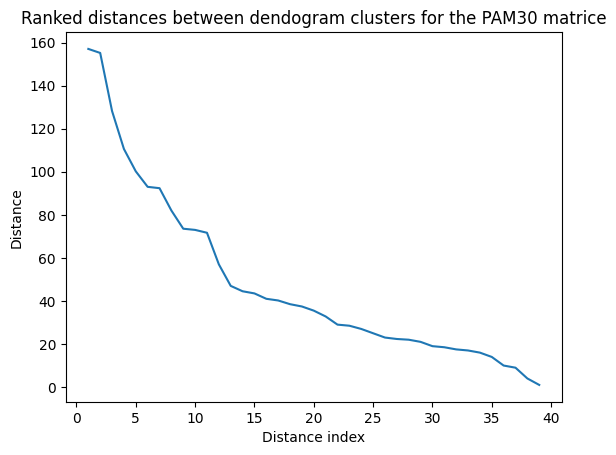

Calculate distances: 0.056824445724487305
Distances array: 0.00016117095947265625
Linkage: 0.0010879039764404297
Plot: 1.2011618614196777
Clusters: 0.000621795654296875
[('clst_0', 3), ('clst_1', 2), ('clst_2', 13), ('clst_3', 9), ('clst_4', 13)]
{'clst_0': [['HLA-A*23:01'], ['HLA-A*24:02', 'HLA-A*24:01'], ['HLA-A*24:03']], 'clst_1': [['HLA-A*01:01'], ['HLA-A*80:01']], 'clst_2': [['HLA-A*02:01'], ['HLA-A*02:02'], ['HLA-A*02:03'], ['HLA-A*02:04'], ['HLA-A*02:05'], ['HLA-A*02:06'], ['HLA-A*02:07'], ['HLA-A*02:11'], ['HLA-A*02:12'], ['HLA-A*02:16'], ['HLA-A*02:17'], ['HLA-A*02:19'], ['HLA-A*02:50']], 'clst_3': [['HLA-A*25:01'], ['HLA-A*26:01'], ['HLA-A*26:02'], ['HLA-A*26:03'], ['HLA-A*66:01'], ['HLA-A*68:01'], ['HLA-A*68:02'], ['HLA-A*68:23'], ['HLA-A*69:01']], 'clst_4': [['HLA-A*03:01'], ['HLA-A*03:02'], ['HLA-A*03:19'], ['HLA-A*11:01', 'HLA-A*11:02'], ['HLA-A*29:02'], ['HLA-A*30:01'], ['HLA-A*30:02'], ['HLA-A*31:01'], ['HLA-A*32:01'], ['HLA-A*32:07'], ['HLA-A*32:15'], ['HLA-A*33:01'], 

<Figure size 640x480 with 0 Axes>

In [15]:

sequences_A =list(set( list(genes['A'].values())))
labels_A = get_unique_alleles(sequences=sequences_A, hla_dict=genes['A'])

clusters_A = cluster_peptides(
    sequences=sequences_A,
    matrix='PAM30',
    n_jobs = 1,
    n_clusters = 102,
    frag_len = 37,
    make_graphs=True,
    labels = labels_A,
    prefix_name='A',
    truncate_p = 12
)

names_clusters['A'] = {clst : [name for seq, name in inv_genes['A'].items() if any(seq ==x[0] for x in clusters_A[clst])] for clst in clusters_A}
print([(n, len(names_clusters['A'][n])) for n in names_clusters['A']])
print(names_clusters['A'])

In [30]:
for gene in names_clusters:
    for clst in names_clusters[gene]:
        el = []
        [el.extend(x) for x in names_clusters[gene][clst]]
        names_clusters[gene][clst] = el

{'A': {'clst_0': ['HLA-A*23:01', 'HLA-A*24:02', 'HLA-A*24:01', 'HLA-A*24:03'],
  'clst_1': ['HLA-A*01:01', 'HLA-A*80:01'],
  'clst_2': ['HLA-A*02:01',
   'HLA-A*02:02',
   'HLA-A*02:03',
   'HLA-A*02:04',
   'HLA-A*02:05',
   'HLA-A*02:06',
   'HLA-A*02:07',
   'HLA-A*02:11',
   'HLA-A*02:12',
   'HLA-A*02:16',
   'HLA-A*02:17',
   'HLA-A*02:19',
   'HLA-A*02:50'],
  'clst_3': ['HLA-A*25:01',
   'HLA-A*26:01',
   'HLA-A*26:02',
   'HLA-A*26:03',
   'HLA-A*66:01',
   'HLA-A*68:01',
   'HLA-A*68:02',
   'HLA-A*68:23',
   'HLA-A*69:01'],
  'clst_4': ['HLA-A*03:01',
   'HLA-A*03:02',
   'HLA-A*03:19',
   'HLA-A*11:01',
   'HLA-A*11:02',
   'HLA-A*29:02',
   'HLA-A*30:01',
   'HLA-A*30:02',
   'HLA-A*31:01',
   'HLA-A*32:01',
   'HLA-A*32:07',
   'HLA-A*32:15',
   'HLA-A*33:01',
   'HLA-A*74:01']},
 'B': {'clst_0': ['HLA-B*15:17',
   'HLA-B*57:01',
   'HLA-B*57:02',
   'HLA-B*57:03',
   'HLA-B*58:01',
   'HLA-B*58:02'],
  'clst_1': ['HLA-B*13:02',
   'HLA-B*15:01',
   'HLA-B*15:02',
   'HLA

In [38]:
target_clusters = {'A' : ['clst_0', 'clst_1'], 'B': ['clst_0'], 'C' : ['clst_0']}

testA_mask = data['allele'].isin(list(itertools.chain(*[names_clusters['A'][i] for i in target_clusters['A']])))
trainA_mask = data['allele'].str.contains('HLA-A') & ~ testA_mask
print('A')
print(f'Train: {len(data[trainA_mask])}')
print(f'Test: {len(data[testA_mask])}')
print(f'Test ratio: {len(data[testA_mask])/(len(data[testA_mask])+len(data[trainA_mask])):.2f}')

testB_mask = data['allele'].isin(list(itertools.chain(*[names_clusters['B'][i] for i in target_clusters['B']])))
trainB_mask = data['allele'].str.contains('HLA-B') & ~ testB_mask
print('B')
print(f'Train: {len(data[trainB_mask])}')
print(f'Test: {len(data[testB_mask])}')
print(f'Test ratio: {len(data[testB_mask])/(len(data[testB_mask])+len(data[trainB_mask])):.2f}')

testC_mask = data['allele'].isin(list(itertools.chain(*[names_clusters['C'][i] for i in target_clusters['C']])))
trainC_mask = data['allele'].str.contains('HLA-C') & ~ testC_mask
print('C')
print(f'Train: {len(data[trainC_mask])}')
print(f'Test: {len(data[testC_mask])}')
print(f'Test ratio: {len(data[testC_mask])/(len(data[testC_mask])+len(data[trainC_mask])):.2f}')

A
Train: 65246
Test: 7324
Test ratio: 0.10
B
Train: 23553
Test: 2930
Test ratio: 0.11
C
Train: 1078
Test: 147
Test ratio: 0.12


In [53]:
test = testA_mask + testB_mask + testC_mask
train = trainA_mask + trainB_mask + trainC_mask 
data['allele_clustering'] = np.select([test, train], [1, 0])
data['allele_clustering'].value_counts()

data.to_csv('/projects/0/einf2380/data/external/processed/I/BA_pMHCI_human_quantitative_only_eq_alleleclusters.csv')


KeyError: 'clst_5'